<a href="https://colab.research.google.com/github/wildhugecoconut/Nuclio_Kaggle_Comp/blob/main/kaggle_nico_ML2_HOUSE_PRICING_Torneo_de_modelos%2C_Cross_validation%2C_y_Hiperparametros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HOUSE PRICING: Cross-validation, Competicion ML y Hiperparametros**

**TAREA: REGRESIÓN**<br>
**NIVEL: INTERMEDIATE**
<br>
Vamos a realizar un torneo de modelos con algunos modelos de regresión. Para ello utilizaremos un dataset de precios de propiedades en Ames, Iowa.

# Librerias

In [1]:
# Datos
import numpy as np
import pandas as pd

# Visualizacion
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from random import random

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from scipy import stats

# Evaluacion
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

#Tamño default de los plots
plt.rcParams["figure.figsize"] = [10,6]

# Load dataset

Dataset source: https://www.perkinsml.me/ames-housing

### EDA: Análisis exploratorio

* En datasets con POCAS VARIABLES (como es el caso) podemos permitirnos explorar visualmente las distribuciones de las variables (analisis univariable) y de las relaciones entre variables (analisis multivariable) para tener mas conocimiento de los datos.
* En datasets con MUCHAS VARIABLES (>20) obviaremos este paso pues el analisis visual se vuelve complejo y no ayuda.

In [2]:
#target = 'PRECIO'
#features = df.columns[df.columns!=target]

In [3]:
#df.describe().T

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
df=pd.read_pickle("/content/drive/MyDrive/Nuclio Capstone Project/pickle_de_nico")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14484 entries, 0 to 14483
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date                            14484 non-null  datetime64[ns]
 1   unique_id                       14484 non-null  object        
 2   city_id                         14484 non-null  int64         
 3   shop_id                         14484 non-null  int64         
 4   item_category_id                14484 non-null  int64         
 5   item_id                         14484 non-null  int64         
 6   monthly_average_price           14484 non-null  float64       
 7   monthly_sales                   14484 non-null  float64       
 8   year                            14484 non-null  int64         
 9   month                           14484 non-null  int64         
 10  day                             14484 non-null  int64         
 11  mo

In [7]:
del(df["date"])

In [8]:
df.set_index("unique_id",inplace=True)

In [9]:
df.fillna(-999,inplace=True)

In [10]:
target = 'monthly_sales'
features = df.columns[df.columns!=target]

# Divide dataset en matriz de variables (X) y output (y)
X = df[features]
y = df[target]

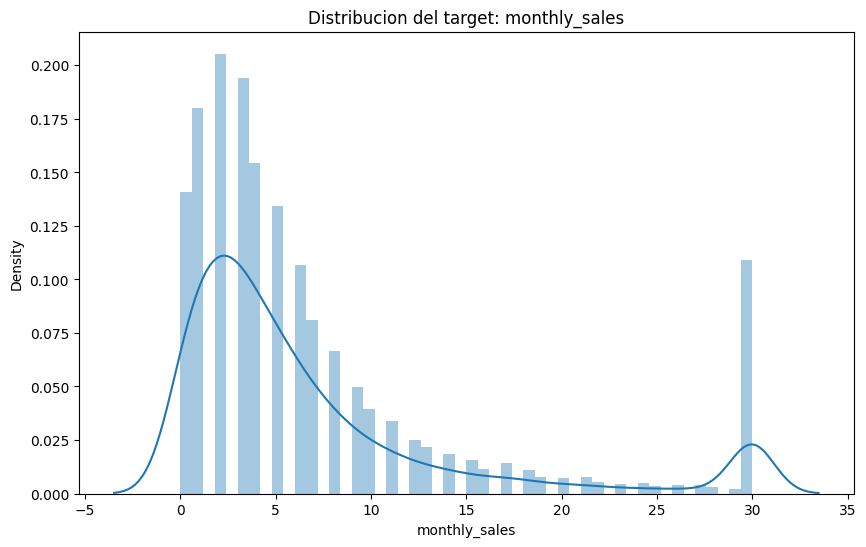

In [11]:
#Distribucion target
sns.distplot(y)
plt.title('Distribucion del target: '+target)
plt.show()

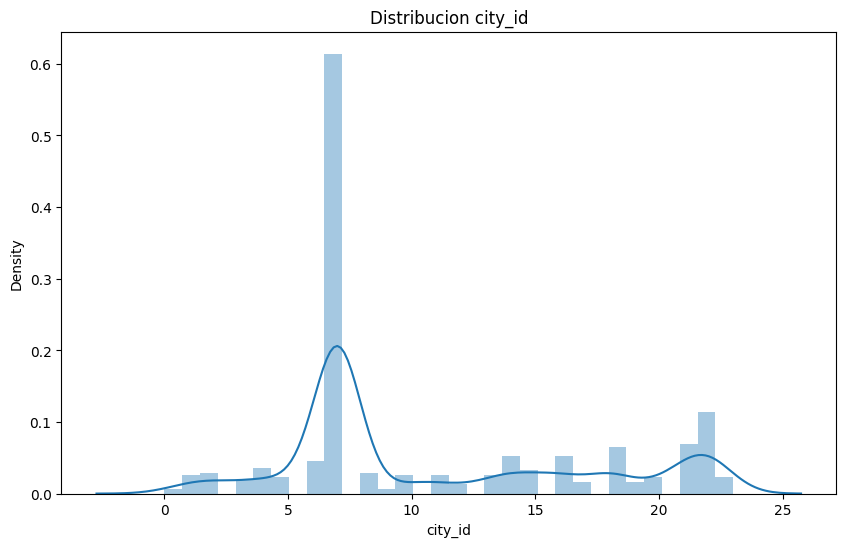

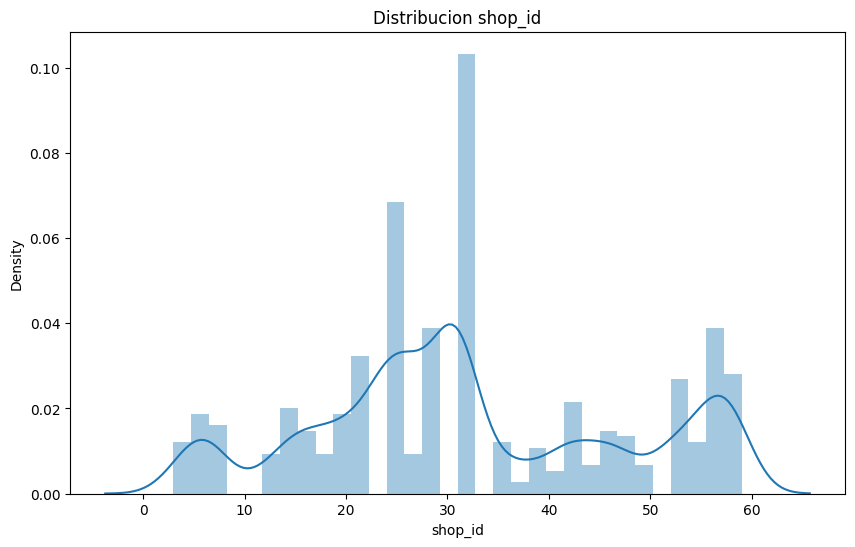

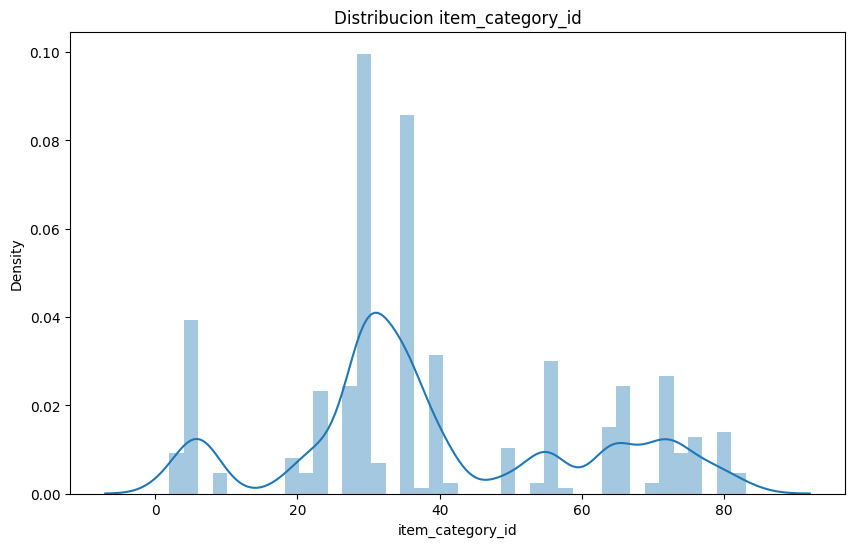

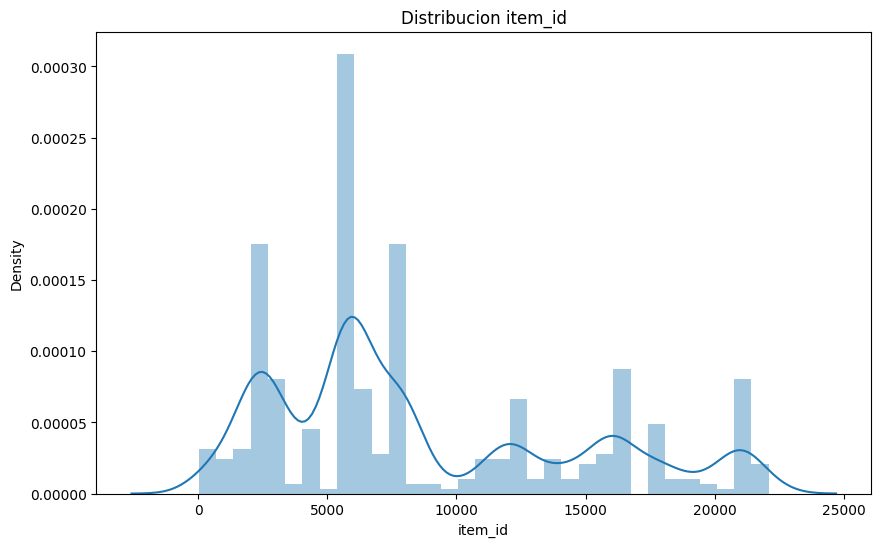

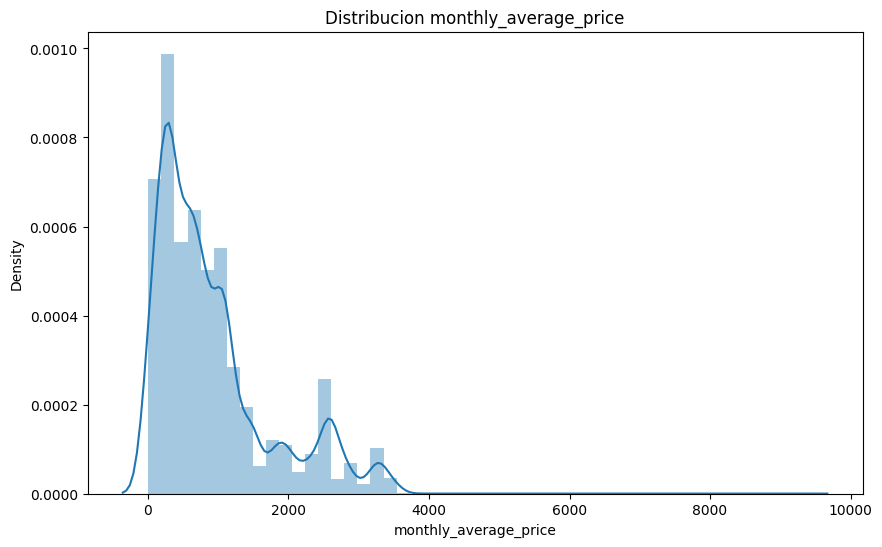

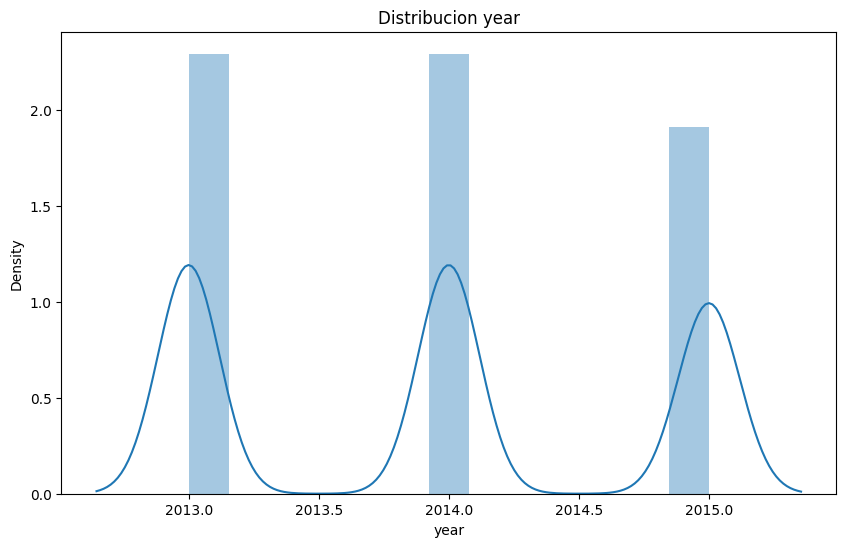

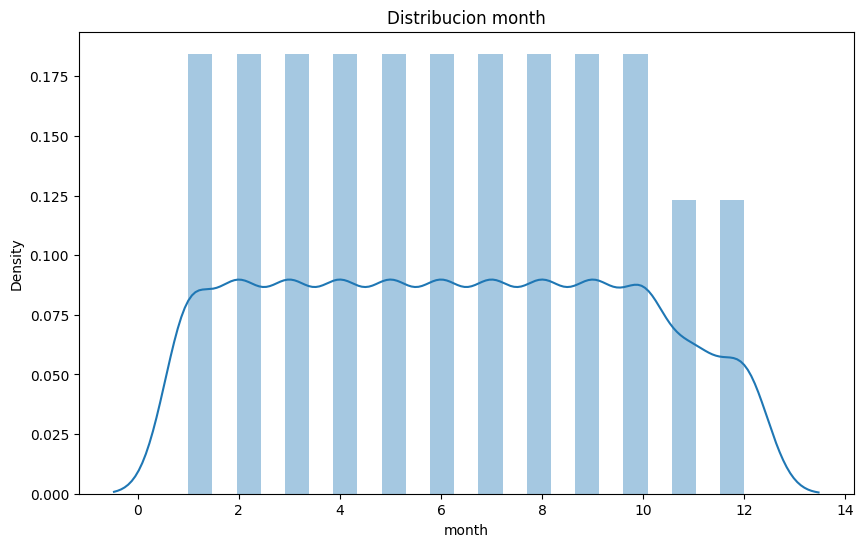

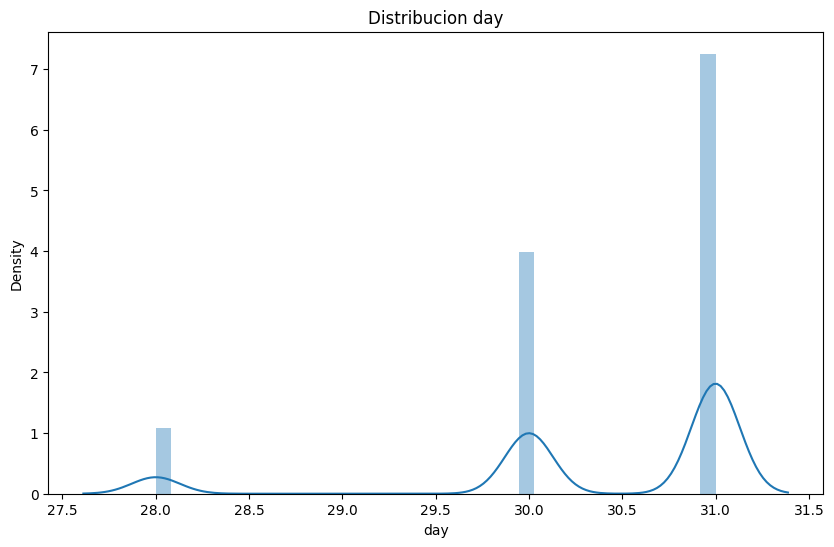

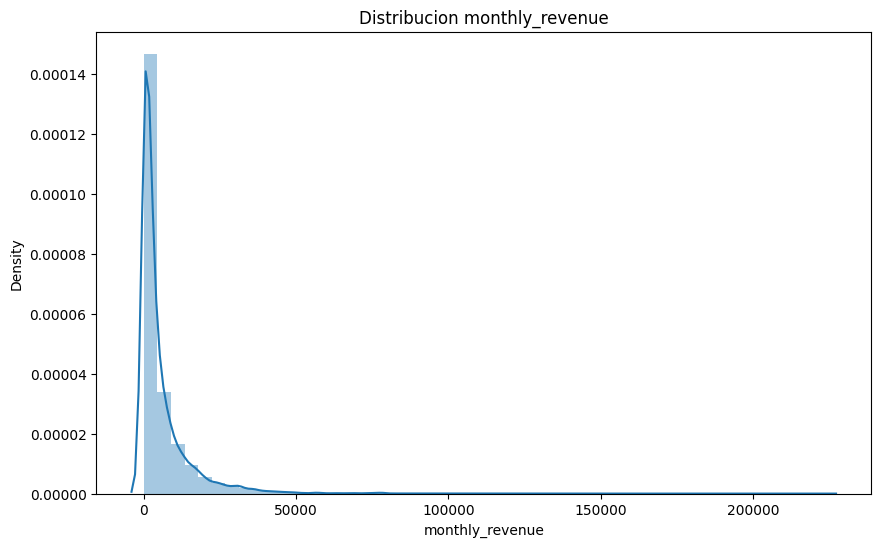

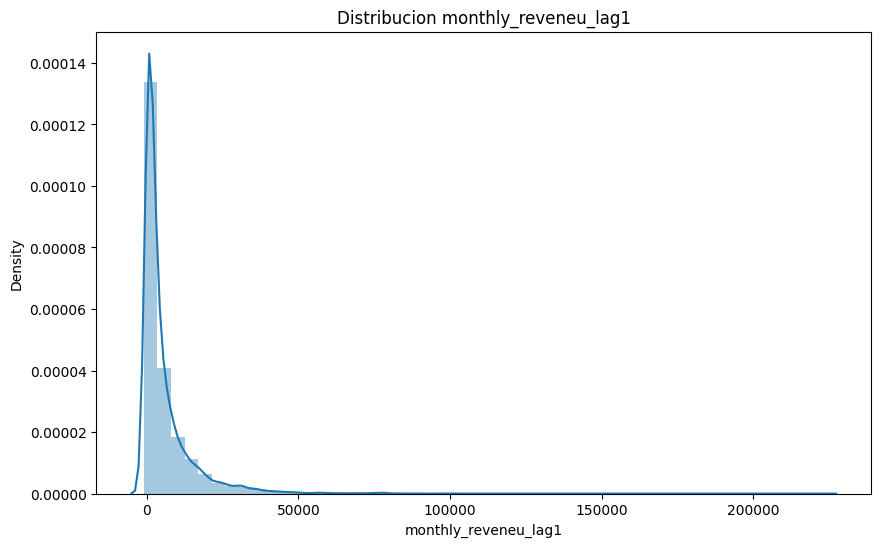

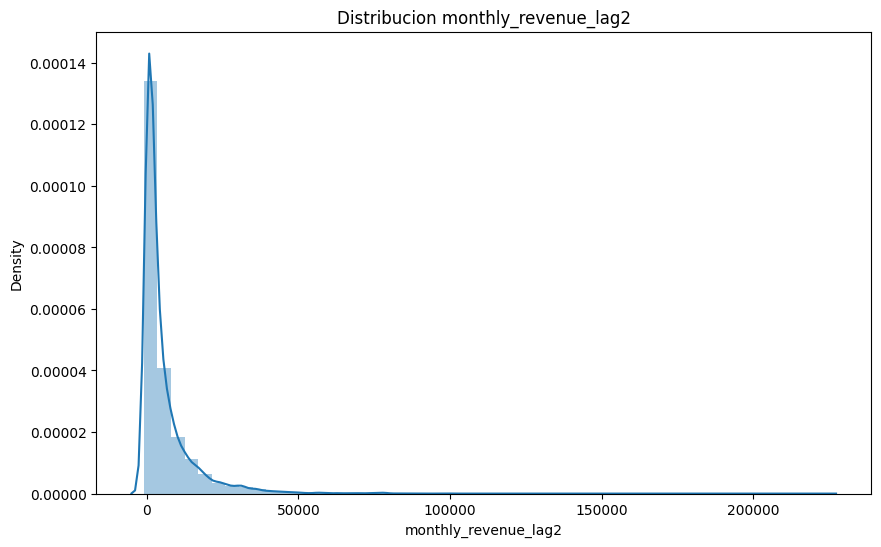

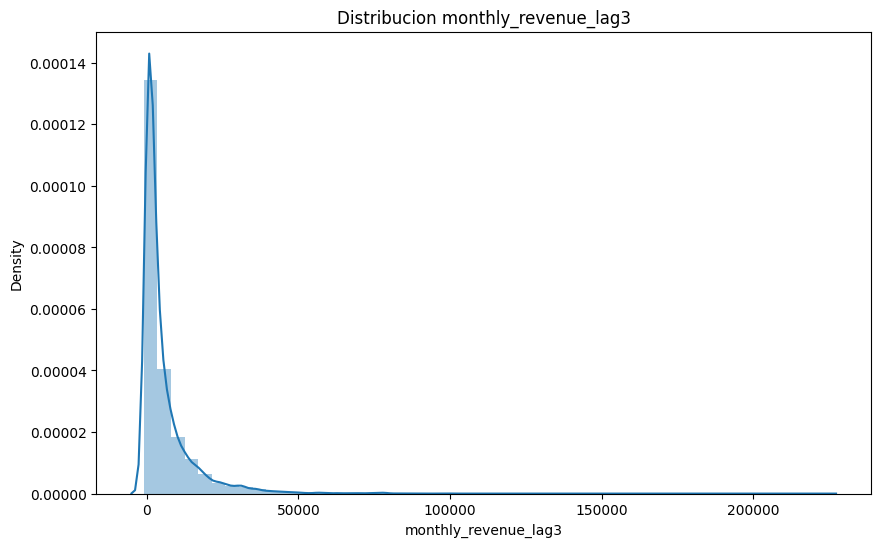

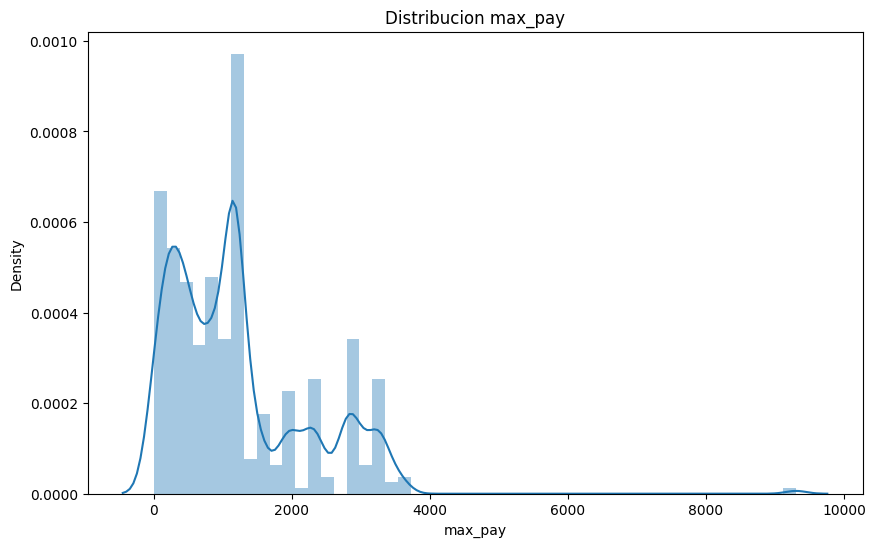

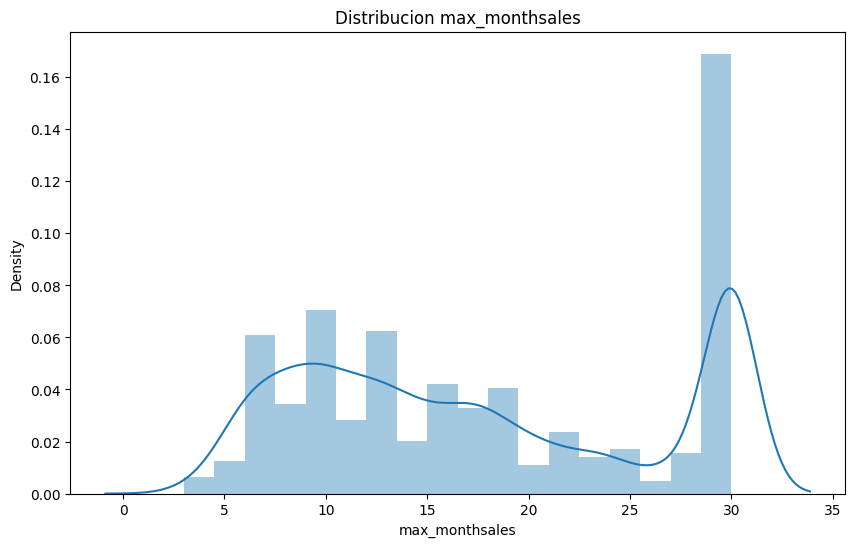

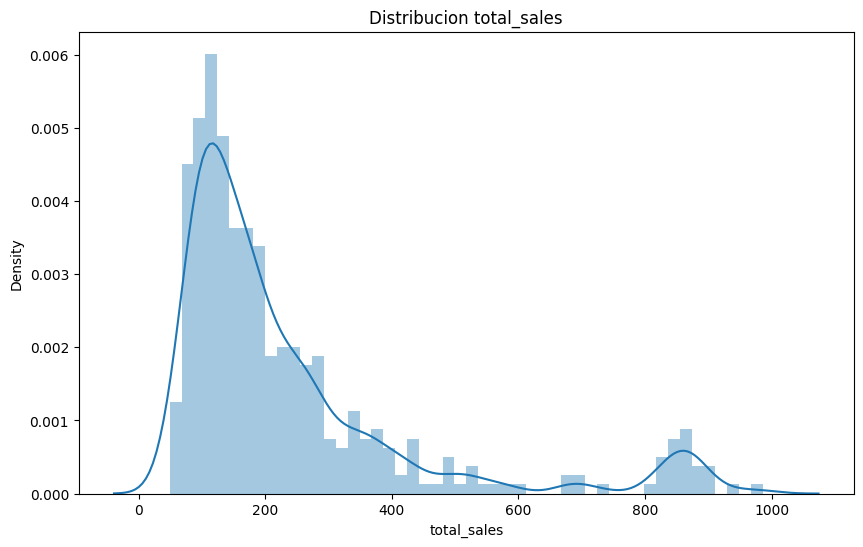

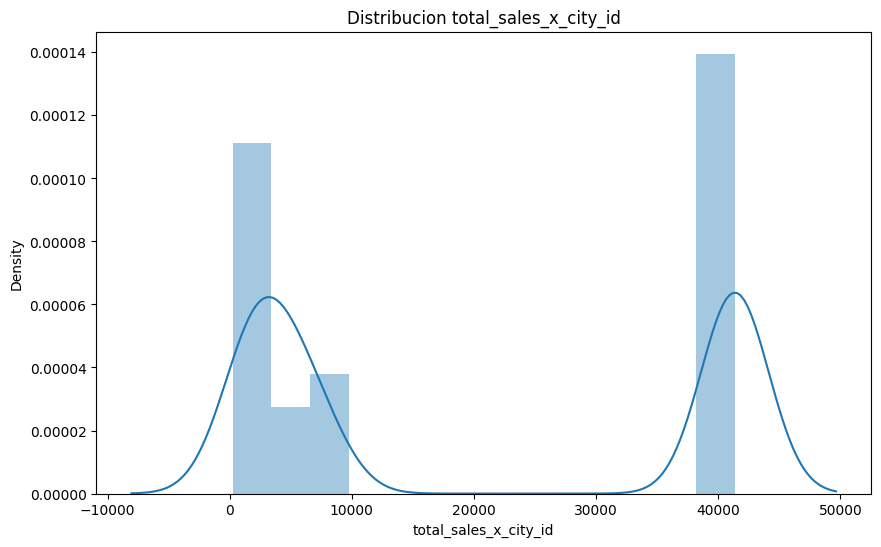

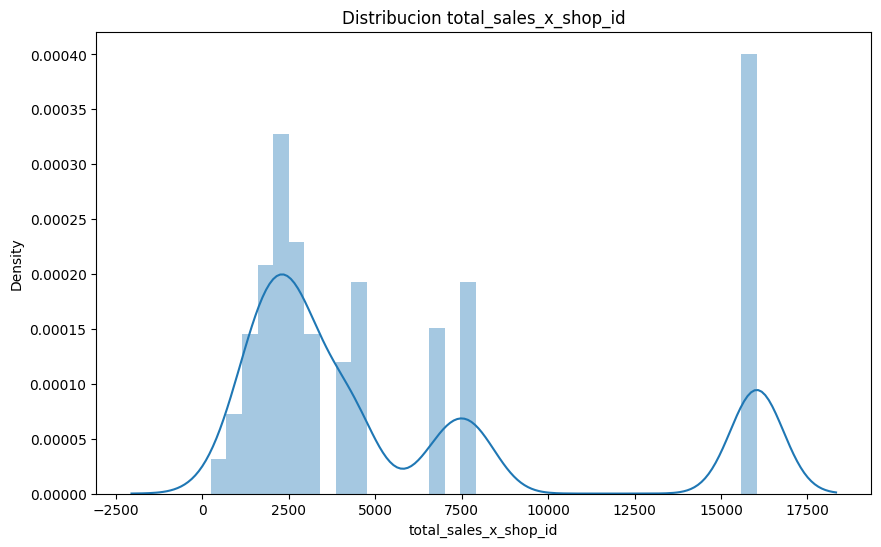

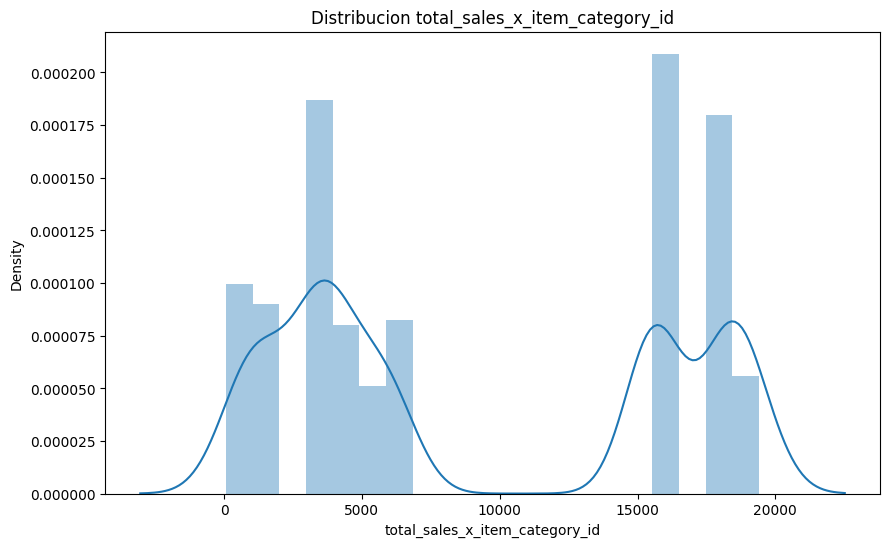

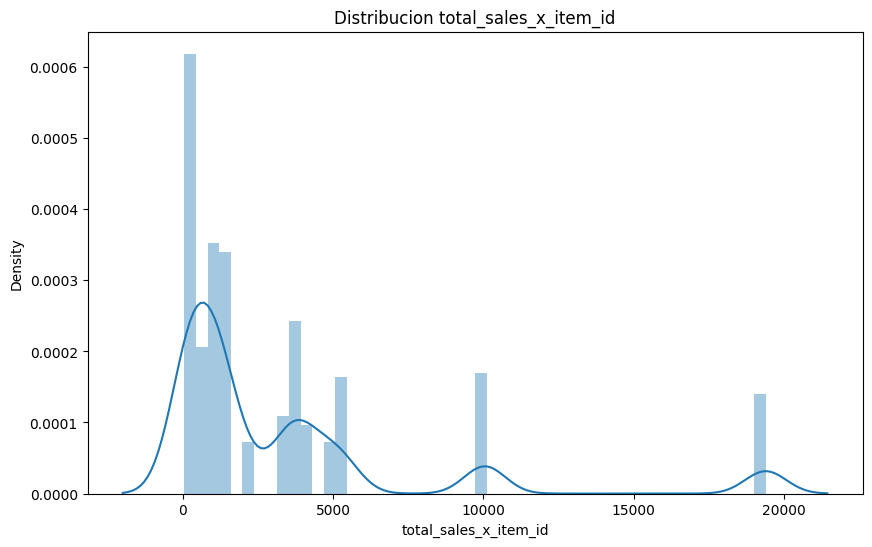

In [12]:
for i in features:
  sns.distplot(X[i])
  plt.title('Distribucion '+i)
  plt.show()

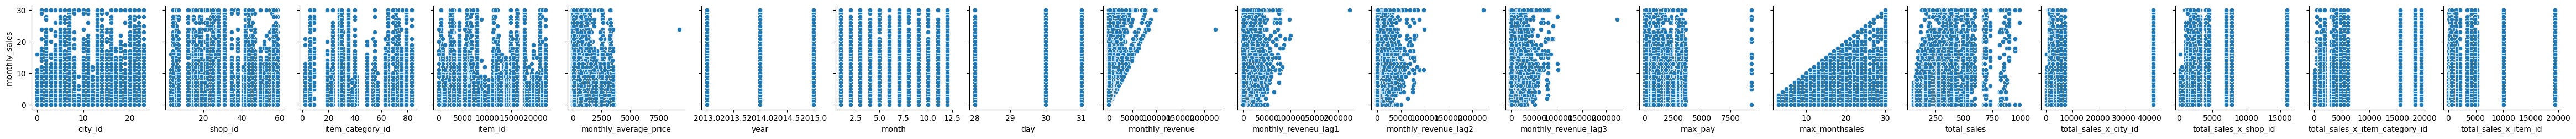

In [13]:
#Dispersion target-variable
sns.pairplot(df,x_vars=features, y_vars=target)
plt.show()

### Imputar nulos

In [14]:
df.isnull().sum()

city_id                           0
shop_id                           0
item_category_id                  0
item_id                           0
monthly_average_price             0
monthly_sales                     0
year                              0
month                             0
day                               0
monthly_revenue                   0
monthly_reveneu_lag1              0
monthly_revenue_lag2              0
monthly_revenue_lag3              0
max_pay                           0
max_monthsales                    0
total_sales                       0
total_sales_x_city_id             0
total_sales_x_shop_id             0
total_sales_x_item_category_id    0
total_sales_x_item_id             0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14484 entries, 12_11365 to 59_22088
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   city_id                         14484 non-null  int64  
 1   shop_id                         14484 non-null  int64  
 2   item_category_id                14484 non-null  int64  
 3   item_id                         14484 non-null  int64  
 4   monthly_average_price           14484 non-null  float64
 5   monthly_sales                   14484 non-null  float64
 6   year                            14484 non-null  int64  
 7   month                           14484 non-null  int64  
 8   day                             14484 non-null  int64  
 9   monthly_revenue                 14484 non-null  float64
 10  monthly_reveneu_lag1            14484 non-null  float64
 11  monthly_revenue_lag2            14484 non-null  float64
 12  monthly_revenue_lag3       

## Encoding categoricos

In [16]:
# No hay categoricos

## Eliminar alta correlación

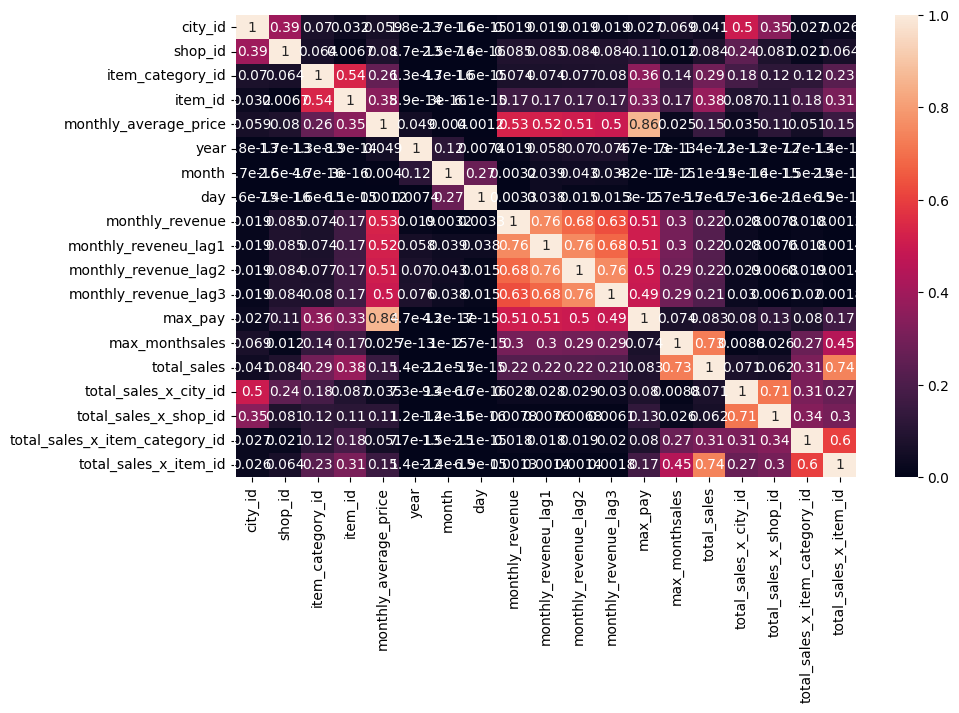

In [17]:
sns.heatmap(X.corr().abs(),annot=True)
plt.show()

In [18]:
# Mismo analisis, pero desde una funcion que nos facilita la vida
def highly_correlated(X, y, threshold):
    col_corr = list() # Set of all the names of deleted columns
    colnames = list()
    rownames = list()
    corr_matrix = X.corr().abs()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colnames.append(corr_matrix.columns[i]) # getting the name of column
                rownames.append(corr_matrix.index[j])
                col_corr.append(corr_matrix.iloc[i, j])
    Z = pd.DataFrame({'F1':colnames,
                      'F2':rownames,
                      'corr_F1_F2':col_corr,
                      'corr_F1_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in colnames],
                      'corr_F2_target': [np.abs(np.corrcoef(X[i],y)[0,1]) for i in rownames]
                      })
    Z['F_to_delete'] = rownames
    Z['F_to_delete'][Z['corr_F1_target'] < Z['corr_F2_target']] = Z['F1'][Z['corr_F1_target'] < Z['corr_F2_target']]

    return Z

highly_corr = highly_correlated(X,y,0.95)
highly_corr

,F1,F2,corr_F1_F2,corr_F1_target,corr_F2_target,F_to_delete


In [19]:
# Eliminamos las features altamente correlacionadas
drop_cols = list(highly_corr['F_to_delete'])
X.drop(columns=drop_cols, inplace=True)
print('Eliminadas columnas altamente correlacionadas:', drop_cols)

Eliminadas columnas altamente correlacionadas: []


In [20]:
X.head(3)

,city_id,shop_id,item_category_id,item_id,monthly_average_price,year,month,day,monthly_revenue,monthly_reveneu_lag1,monthly_revenue_lag2,monthly_revenue_lag3,max_pay,max_monthsales,total_sales,total_sales_x_city_id,total_sales_x_shop_id,total_sales_x_item_category_id,total_sales_x_item_id
unique_id,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,2013,1,31,45345.378788,-999.000000,-999.000000,-999.0,9305.121212,30.0,674.0,6593.0,4154.0,3469.0,674.0
12_11365,16,12,9,11365,1533.125000,2013,2,28,41394.375000,45345.378788,-999.000000,-999.0,9305.121212,30.0,674.0,6593.0,4154.0,3469.0,674.0
12_11365,16,12,9,11365,3252.470238,2013,3,31,97574.107143,41394.375000,45345.378788,-999.0,9305.121212,30.0,674.0,6593.0,4154.0,3469.0,674.0


## Eliminar baja varianza

In [21]:
# Filtrar solo las columnas numéricas
numeric_columns = X.select_dtypes(include=['number'])

# Eliminar columnas con baja varianza
vt = VarianceThreshold(threshold=0.01)
vt.fit(numeric_columns)

# Obtener las columnas con baja varianza
cols_lowvar = numeric_columns.columns[vt.get_support() == False]

# Eliminar las columnas con baja varianza del dataframe original
X.drop(columns=cols_lowvar, inplace=True)

print(len(cols_lowvar), ' low variance features were removed:\n', cols_lowvar.to_list())


0  low variance features were removed:
 []


In [22]:
'''
# Eliminamos columnas practicamente constantes (nula varianza)
vt = VarianceThreshold(threshold = 0.01)
vt.fit(X)

cols_lowvar = X.columns[vt.get_support()==False]
X.drop(columns=cols_lowvar,inplace=True)

print(len(cols_lowvar),' low variance features were removed:\n', cols_lowvar.to_list())
'''

"\n# Eliminamos columnas practicamente constantes (nula varianza)\nvt = VarianceThreshold(threshold = 0.01)\nvt.fit(X)\n\ncols_lowvar = X.columns[vt.get_support()==False]\nX.drop(columns=cols_lowvar,inplace=True)\n\nprint(len(cols_lowvar),' low variance features were removed:\n', cols_lowvar.to_list())\n"

# TRAIN

## Split train-test

Para el test dejamos entre un 10%-30% del dataset original. 10% cuando el dataset es pequeño (<10k), 20-30% cuando el dataset es grande (>100k).

In [23]:
# Divide X-y en Train (85%) y Test (15%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [24]:
print('Train set size:',X_train.shape[0])
print('Test set size:',X_test.shape[0])

Train set size: 13035
Test set size: 1449


## Rescaling

In [25]:
df

,city_id,shop_id,item_category_id,item_id,monthly_average_price,monthly_sales,year,month,day,monthly_revenue,monthly_reveneu_lag1,monthly_revenue_lag2,monthly_revenue_lag3,max_pay,max_monthsales,total_sales,total_sales_x_city_id,total_sales_x_shop_id,total_sales_x_item_category_id,total_sales_x_item_id
unique_id,,,,,,,,,,,,,,,,,,,,
12_11365,16,12,9,11365,1511.512626,30.0,2013,1,31,45345.378788,-999.000000,-999.000000,-999.000000,9305.121212,30.0,674.0,6593.0,4154.0,3469.0,674.0
12_11365,16,12,9,11365,1533.125000,27.0,2013,2,28,41394.375000,45345.378788,-999.000000,-999.000000,9305.121212,30.0,674.0,6593.0,4154.0,3469.0,674.0
12_11365,16,12,9,11365,3252.470238,30.0,2013,3,31,97574.107143,41394.375000,45345.378788,-999.000000,9305.121212,30.0,674.0,6593.0,4154.0,3469.0,674.0
12_11365,16,12,9,11365,1590.515152,27.0,2013,4,30,42943.909091,97574.107143,41394.375000,45345.378788,9305.121212,30.0,674.0,6593.0,4154.0,3469.0,674.0
12_11365,16,12,9,11365,1447.531250,30.0,2013,5,31,43425.937500,42943.909091,97574.107143,41394.375000,9305.121212,30.0,674.0,6593.0,4154.0,3469.0,674.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59_22088,23,59,83,22088,119.000000,4.0,2015,6,30,476.000000,357.000000,357.000000,476.000000,119.000000,21.0,196.0,2001.0,2001.0,1106.0,623.0
59_22088,23,59,83,22088,119.000000,7.0,2015,7,31,833.000000,476.000000,357.000000,357.000000,119.000000,21.0,196.0,2001.0,2001.0,1106.0,623.0
59_22088,23,59,83,22088,119.000000,7.0,2015,8,31,833.000000,833.000000,476.000000,357.000000,119.000000,21.0,196.0,2001.0,2001.0,1106.0,623.0


In [26]:
# Estandarización: fit_transform() en train, transform() en test
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train_std = pd.DataFrame(X_train_std, columns = X_train.columns, index= X_train.index)
X_test_std = pd.DataFrame(X_test_std, columns = X_test.columns, index= X_test.index)

In [27]:
X_train_std.head(3)

,city_id,shop_id,item_category_id,item_id,monthly_average_price,year,month,day,monthly_revenue,monthly_reveneu_lag1,monthly_revenue_lag2,monthly_revenue_lag3,max_pay,max_monthsales,total_sales,total_sales_x_city_id,total_sales_x_shop_id,total_sales_x_item_category_id,total_sales_x_item_id
unique_id,,,,,,,,,,,,,,,,,,,
47_4249,0.672763,0.989578,-0.803186,-0.741690,0.348291,-1.171421,1.741357,0.670690,0.041755,-0.225440,-0.395592,-0.220763,0.674415,-0.084833,-0.614280,-1.006339,-0.837997,-0.790669,-0.580637
58_7895,1.798125,1.711958,-1.635216,-0.124774,-0.017185,0.074965,0.836478,-0.471068,-0.226715,-0.127631,-0.410927,-0.286647,-0.018907,-0.883980,-0.654412,-0.695326,-0.553146,-0.446657,-0.606123
42_1905,0.511997,0.661223,-0.460586,-1.138303,-0.809049,1.321351,-1.274907,-2.754586,-0.545544,-0.508739,-0.427869,-0.533191,-0.939100,-1.226472,-0.599230,-0.845878,-0.258286,0.896005,-0.480205


## Torneo de Modelos

**K-Fold Cross validation**<br>
Devuelve el predict promedio de k modelos entrenados con distintas particiones para el test. Es más fiable y robusto sobre todo en datasets pequeños.

* La metrica del score la dicta cada modelo. Ver documentacion de cada modelo en scikitlearn para saber qué metrica es el score. Por defecto en regresion suele ser el R2-score pero podemos utilizar otras metricas: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [29]:
X_train.isnull().sum()

city_id                           0
shop_id                           0
item_category_id                  0
item_id                           0
monthly_average_price             0
year                              0
month                             0
day                               0
monthly_revenue                   0
monthly_reveneu_lag1              0
monthly_revenue_lag2              0
monthly_revenue_lag3              0
max_pay                           0
max_monthsales                    0
total_sales                       0
total_sales_x_city_id             0
total_sales_x_shop_id             0
total_sales_x_item_category_id    0
total_sales_x_item_id             0
dtype: int64

In [30]:
model = LinearRegression()
np.mean(-cross_val_score(model, X_train, y_train, cv=4, scoring='neg_root_mean_squared_error'))

4.043355492862855

Para la proxima parte vamos a crear funciones que nos ayuden a evaluar el error rapidamente en los diferentes modelos:

In [31]:
# Modelos ML de Regresion
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor

In [32]:
def RMSE(model,X,y):
  model.fit(X,y)
  return round(np.sqrt(np.mean((y-model.predict(X))**2)),2)

def RMSE_cross_validation(model,X,y):
  Kfold_rmse = cross_val_score(model, X, y, cv=4, scoring='neg_root_mean_squared_error')
  return round(-Kfold_rmse.mean(),4)

In [33]:
# Inicializa resultados
label_ = []
rmse_train_ = []
rmse_valida_ = []

# Funcion que devuelve un dataframe con resultados de RMSE Cross Validation
def evaluate_regression(model, X, y, label=None):
  if label is None:
    label = str(model)

  rmse_train = RMSE(model,X,y)
  rmse_valida = RMSE_cross_validation(model,X,y)

  label_.append(label)
  rmse_train_.append(rmse_train)
  rmse_valida_.append(rmse_valida)

  return pd.DataFrame({'Model': label_,
                      'RMSE Train': rmse_train_,
                      'RMSE Cross-Validation': rmse_valida_
                      }).sort_values('RMSE Cross-Validation')

In [34]:
evaluate_regression(model = LinearRegression(),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),4.04,4.0434


**Regresión Lineal + Regularización: LASSO, Ridge y ElasticNet**

In [35]:
evaluate_regression(model = Lasso(alpha=1),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),4.04,4.0434
1,Lasso(alpha=1),4.69,4.6919


In [36]:
evaluate_regression(model = Ridge(alpha=1),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),4.04,4.0434
2,Ridge(alpha=1),4.04,4.0434
1,Lasso(alpha=1),4.69,4.6919


In [37]:
evaluate_regression(model = ElasticNet(l1_ratio=0.5),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),4.04,4.0434
2,Ridge(alpha=1),4.04,4.0434
1,Lasso(alpha=1),4.69,4.6919
3,ElasticNet(),4.84,4.8397


**Polynomial Regression**

In [38]:
'''
evaluate_regression(label='Polynomial 5d',
                    model = LinearRegression(),
                    X=X_train_poly, y=y_train)
'''

"\nevaluate_regression(label='Polynomial 5d',\n                    model = LinearRegression(),\n                    X=X_train_poly, y=y_train)\n"

**Stochastic Gradient Descent**

In [39]:
evaluate_regression(model = SGDRegressor(n_iter_no_change=100, penalty=None, eta0=0.01, max_iter=10000),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
0,LinearRegression(),4.04,4.0434
2,Ridge(alpha=1),4.04,4.0434
4,"SGDRegressor(max_iter=10000, n_iter_no_change=...",4.04,4.0556
1,Lasso(alpha=1),4.69,4.6919
3,ElasticNet(),4.84,4.8397


**Naive-Bayes**

**KNN Regressor**

In [40]:
evaluate_regression(model = KNeighborsRegressor(n_neighbors = 10),
                    X=X_train_std, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
5,KNeighborsRegressor(n_neighbors=10),3.06,3.5483
0,LinearRegression(),4.04,4.0434
2,Ridge(alpha=1),4.04,4.0434
4,"SGDRegressor(max_iter=10000, n_iter_no_change=...",4.04,4.0556
1,Lasso(alpha=1),4.69,4.6919
3,ElasticNet(),4.84,4.8397


**Random Forest Regressor**

In [41]:
evaluate_regression(model = RandomForestRegressor(n_estimators=100, max_depth=3),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
5,KNeighborsRegressor(n_neighbors=10),3.06,3.5483
6,RandomForestRegressor(max_depth=3),3.69,3.7132
0,LinearRegression(),4.04,4.0434
2,Ridge(alpha=1),4.04,4.0434
4,"SGDRegressor(max_iter=10000, n_iter_no_change=...",4.04,4.0556
1,Lasso(alpha=1),4.69,4.6919
3,ElasticNet(),4.84,4.8397


**XGBoost Regressor**

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13035 entries, 47_4249 to 31_1905
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   city_id                         13035 non-null  int64  
 1   shop_id                         13035 non-null  int64  
 2   item_category_id                13035 non-null  int64  
 3   item_id                         13035 non-null  int64  
 4   monthly_average_price           13035 non-null  float64
 5   year                            13035 non-null  int64  
 6   month                           13035 non-null  int64  
 7   day                             13035 non-null  int64  
 8   monthly_revenue                 13035 non-null  float64
 9   monthly_reveneu_lag1            13035 non-null  float64
 10  monthly_revenue_lag2            13035 non-null  float64
 11  monthly_revenue_lag3            13035 non-null  float64
 12  max_pay                      

In [43]:
y_train.to_frame().info()

<class 'pandas.core.frame.DataFrame'>
Index: 13035 entries, 47_4249 to 31_1905
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   monthly_sales  13035 non-null  float64
dtypes: float64(1)
memory usage: 719.7+ KB


In [44]:
evaluate_regression(model = XGBRegressor(objective ='reg:squarederror'),
                    X=X_train, y=y_train)

,Model,RMSE Train,RMSE Cross-Validation
7,"XGBRegressor(base_score=None, booster=None, ca...",0.14,0.5567
5,KNeighborsRegressor(n_neighbors=10),3.06,3.5483
6,RandomForestRegressor(max_depth=3),3.69,3.7132
0,LinearRegression(),4.04,4.0434
2,Ridge(alpha=1),4.04,4.0434
4,"SGDRegressor(max_iter=10000, n_iter_no_change=...",4.04,4.0556
1,Lasso(alpha=1),4.69,4.6919
3,ElasticNet(),4.84,4.8397


**NOTA:** Tambien se probó una Red Neuronal ANN y el resultado en validación fue RMSE = 127,795.59 ...

## Hiperparametros

Vamos a utilizar RandomSearch para obtener la mejor configuración del modelo ganador: el Stochastic Gradient Descent (SGD).

In [45]:
from sklearn.model_selection import RandomizedSearchCV

In [46]:
XGBRegressor()

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
#?XGBRegressor

In [48]:
parameters_hp = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 1, 10],
    'reg_lambda': [0, 1, 10]
}


In [49]:
search_hp = RandomizedSearchCV(estimator=XGBRegressor(),
                               param_distributions = parameters_hp,
                               scoring='neg_root_mean_squared_error',     # metrica a optimizar: RMSE
                               cv = 4,                                    # numero de folds para cross-validation
                               n_iter = 40,                               # numero de iteraciones, cada una testeara una configuracion distinta
                               n_jobs=-1,
                               verbose=True)

In [66]:
search_hp.fit(X_train, y_train)

Fitting 4 folds for each of 40 candidates, totalling 160 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, gpu_id=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          num_parallel_tree=None,
                                          predictor=None, random_state=None, ...),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.8, 0.9, 1.0],
                                        'gamma': [0, 1, 5],
                                        'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [50, 100, 200, 300],
                                        'reg_alpha': [0, 1, 10],
                                        'reg_lambda': [0, 1, 10],
                                        'subsample': [0.8, 0.9, 1.0]},
                   scoring='neg_root_mean_squared_error', verbose=True)

In [67]:
search_hp.best_params_

{'subsample': 0.8,
 'reg_lambda': 1,
 'reg_alpha': 0,
 'n_estimators': 300,
 'max_depth': 5,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 1.0}

In [68]:
print("---- Results from Random Search -----" )
print("\n The best estimator across ALL searched params:", search_hp.best_estimator_)
print("\n The best RMSE:", -search_hp.best_score_)
print("\n The best parameters across ALL searched params:\n", search_hp.best_params_)

---- Results from Random Search -----

 The best estimator across ALL searched params: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

 The best RMSE: 0.44672979803068724

 The best parameters across ALL searched params:
 {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 5, 'le

El unico problema de RandomSearch es que no podemos elegir las configuraciones a probar y podria dar con un ajuste de parametros que no es mejor que la configuración por defecto. Asi que es recomendable siempre comprobar que se mejora el  performance que se obtuvo con la configuracion default en la Competicion de Modelos.

In [69]:
X_test

,city_id,shop_id,item_category_id,item_id,monthly_average_price,year,month,day,monthly_revenue,monthly_reveneu_lag1,monthly_revenue_lag2,monthly_revenue_lag3,max_pay,max_monthsales,total_sales,total_sales_x_city_id,total_sales_x_shop_id,total_sales_x_item_category_id,total_sales_x_item_id
unique_id,,,,,,,,,,,,,,,,,,,
44_22088,13,44,83,22088,119.000000,2015,3,31,1190.000000,2023.000000,1858.285714,2673.0,119.000000,30.0,427.0,2706.0,1653.0,1106.0,623.0
31_7894,7,31,6,7894,1490.000000,2013,4,30,25330.000000,34108.784375,7450.000000,23840.0,2306.666667,30.0,494.0,41360.0,16035.0,6138.0,3481.0
28_4248,7,28,23,4248,1499.000000,2014,9,30,1499.000000,4497.000000,3147.000000,4196.6,1999.000000,16.0,166.0,41360.0,6969.0,3706.0,557.0
18_5822,5,18,35,5822,1149.000000,2015,4,30,18384.000000,21197.666667,22449.000000,23078.0,1149.000000,30.0,534.0,1737.0,1737.0,18331.0,10048.0
12_12231,16,12,49,12231,350.000000,2015,10,31,0.000000,700.000000,700.000000,350.0,350.000000,7.0,78.0,6593.0,4154.0,1294.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24_2753,7,24,30,2753,599.000000,2013,10,31,1198.000000,2995.000000,5733.350000,4137.0,1198.750000,25.0,122.0,41360.0,3179.0,15630.0,615.0
44_22088,13,44,83,22088,79.000000,2014,3,31,869.000000,1027.000000,711.000000,2370.0,119.000000,30.0,427.0,2706.0,1653.0,1106.0,623.0
38_7893,10,38,6,7893,2690.000000,2015,10,31,0.000000,5380.000000,12450.000000,14200.0,2890.000000,15.0,155.0,1280.0,1280.0,6138.0,2175.0


## Modelo final

In [70]:
model = search_hp.best_estimator_

In [82]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=300, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# TEST

### Evaluación del error

Veamos en detalle el error que produce el modelo en los datos de Test

* **RMSE, MAE y MAPE**

**Distribución del error**

# Interpretabilidad

Como el dataset fue estandarizado, los coeficientes resultantes de la regresion lineal corresponden a la importancia de cada variable en el resultado del modelo.

# PREDICT

In [86]:
Y_test_predict = model.predict(X_test)
X_test["monthly_sales"] = Y_test_predict

In [87]:
X_test

,city_id,shop_id,item_category_id,item_id,monthly_average_price,year,month,day,monthly_revenue,monthly_reveneu_lag1,monthly_revenue_lag2,monthly_revenue_lag3,max_pay,max_monthsales,total_sales,total_sales_x_city_id,total_sales_x_shop_id,total_sales_x_item_category_id,total_sales_x_item_id,monthly_sales
unique_id,,,,,,,,,,,,,,,,,,,,
44_22088,13,44,83,22088,119.000000,2015,3,31,1190.000000,2023.000000,1858.285714,2673.0,119.000000,30.0,427.0,2706.0,1653.0,1106.0,623.0,10.870121
31_7894,7,31,6,7894,1490.000000,2013,4,30,25330.000000,34108.784375,7450.000000,23840.0,2306.666667,30.0,494.0,41360.0,16035.0,6138.0,3481.0,17.597338
28_4248,7,28,23,4248,1499.000000,2014,9,30,1499.000000,4497.000000,3147.000000,4196.6,1999.000000,16.0,166.0,41360.0,6969.0,3706.0,557.0,0.952483
18_5822,5,18,35,5822,1149.000000,2015,4,30,18384.000000,21197.666667,22449.000000,23078.0,1149.000000,30.0,534.0,1737.0,1737.0,18331.0,10048.0,17.100939
12_12231,16,12,49,12231,350.000000,2015,10,31,0.000000,700.000000,700.000000,350.0,350.000000,7.0,78.0,6593.0,4154.0,1294.0,78.0,0.000835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24_2753,7,24,30,2753,599.000000,2013,10,31,1198.000000,2995.000000,5733.350000,4137.0,1198.750000,25.0,122.0,41360.0,3179.0,15630.0,615.0,1.909125
44_22088,13,44,83,22088,79.000000,2014,3,31,869.000000,1027.000000,711.000000,2370.0,119.000000,30.0,427.0,2706.0,1653.0,1106.0,623.0,10.974817
38_7893,10,38,6,7893,2690.000000,2015,10,31,0.000000,5380.000000,12450.000000,14200.0,2890.000000,15.0,155.0,1280.0,1280.0,6138.0,2175.0,0.018020


In [88]:
X_test.reset_index(inplace = True)

In [94]:
(
    X_test[["unique_id", "monthly_sales"]]
    .to_csv("submission_train_rmse_train_valida_rmse_valida.csv", index = False)
)

In [95]:
X_test

,unique_id,city_id,shop_id,item_category_id,item_id,monthly_average_price,year,month,day,monthly_revenue,...,monthly_revenue_lag2,monthly_revenue_lag3,max_pay,max_monthsales,total_sales,total_sales_x_city_id,total_sales_x_shop_id,total_sales_x_item_category_id,total_sales_x_item_id,monthly_sales
0,44_22088,13,44,83,22088,119.000000,2015,3,31,1190.000000,...,1858.285714,2673.0,119.000000,30.0,427.0,2706.0,1653.0,1106.0,623.0,10.870121
1,31_7894,7,31,6,7894,1490.000000,2013,4,30,25330.000000,...,7450.000000,23840.0,2306.666667,30.0,494.0,41360.0,16035.0,6138.0,3481.0,17.597338
2,28_4248,7,28,23,4248,1499.000000,2014,9,30,1499.000000,...,3147.000000,4196.6,1999.000000,16.0,166.0,41360.0,6969.0,3706.0,557.0,0.952483
3,18_5822,5,18,35,5822,1149.000000,2015,4,30,18384.000000,...,22449.000000,23078.0,1149.000000,30.0,534.0,1737.0,1737.0,18331.0,10048.0,17.100939
4,12_12231,16,12,49,12231,350.000000,2015,10,31,0.000000,...,700.000000,350.0,350.000000,7.0,78.0,6593.0,4154.0,1294.0,78.0,0.000835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,24_2753,7,24,30,2753,599.000000,2013,10,31,1198.000000,...,5733.350000,4137.0,1198.750000,25.0,122.0,41360.0,3179.0,15630.0,615.0,1.909125
1445,44_22088,13,44,83,22088,79.000000,2014,3,31,869.000000,...,711.000000,2370.0,119.000000,30.0,427.0,2706.0,1653.0,1106.0,623.0,10.974817
1446,38_7893,10,38,6,7893,2690.000000,2015,10,31,0.000000,...,12450.000000,14200.0,2890.000000,15.0,155.0,1280.0,1280.0,6138.0,2175.0,0.018020
1447,50_2308,17,50,30,2308,795.000000,2013,2,28,3975.000000,...,0.000000,150.0,849.000000,17.0,142.0,1492.0,1492.0,15630.0,5266.0,5.071630
